In [3]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
from scipy.optimize import minimize

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
from apra_pop_models.math_module import xp, xcipy, ensure_np_array
import apra_pop_models.fresnel_2dm as fresnel
import apra_pop_models.fraunhofer_2dm as fraunhofer
import apra_pop_models.dm as dm
import apra_pop_models.utils as utils
import apra_pop_models.props as props
from apra_pop_models.imshows import imshow1, imshow2, imshow3
import apra_pop_models.aefc_2dm as aefc


/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


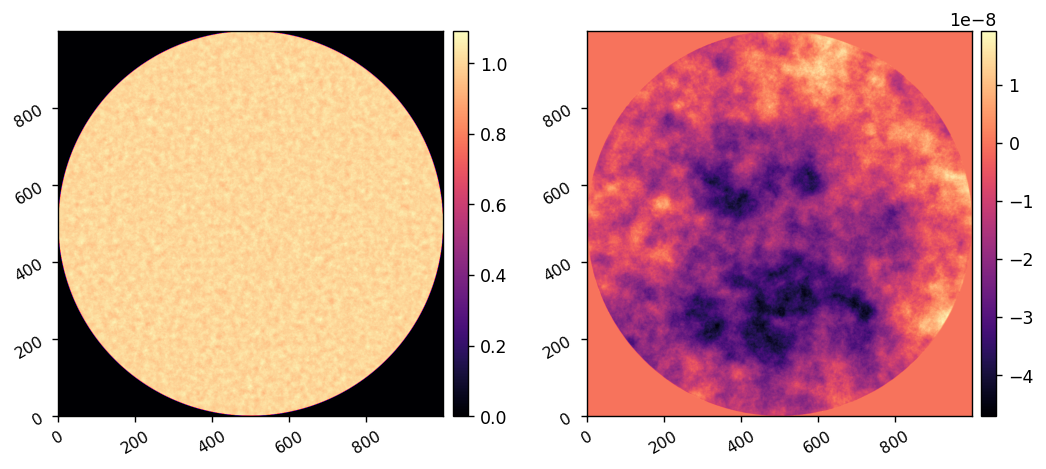

In [4]:
reload(fresnel)
Nact = 96
npsf = 256

I = fresnel.CORO(
    Nact=Nact,
    npsf=npsf,
)
I.use_opds = True

AMP, OPD = I.calc_pupil()
imshow2(AMP, OPD)

/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


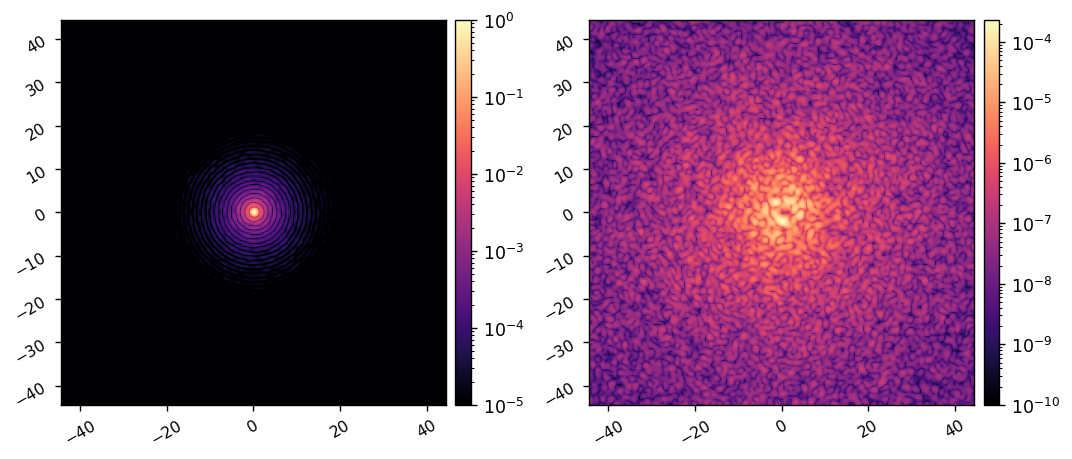

In [5]:
reload(fresnel)

I.use_vortex = False
ref_psf = I.snap()
I.Imax_ref = xp.max(ref_psf)
ref_psf /= I.Imax_ref
I.use_vortex = True
ref_coro_im = I.snap()

imshow2(ref_psf, ref_coro_im,
        pxscl=I.psf_pixelscale_lamDc, lognorm=True, vmin1=1e-5, vmin2=1e-10)


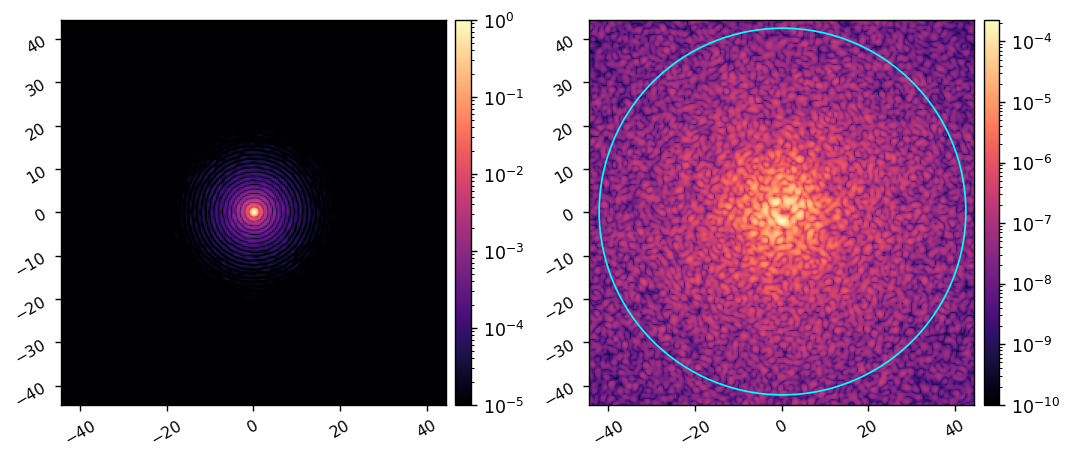

In [6]:
reload(fraunhofer)
M = fraunhofer.MODEL(
    Nact=Nact,
    npsf=npsf,
)
M.AMP = AMP
M.OPD = OPD

M.flip_dm = True
M.flip_lyot = True

acts = xp.zeros(M.Nacts)

model_psf = xp.abs( M.forward(acts, M.wavelength_c, use_vortex=0) )**2
M.setattr('Imax_ref', xp.max(model_psf))
model_psf /= M.Imax_ref

model_coro_im = xp.abs( M.forward(acts, M.wavelength_c, use_vortex=1) )**2

imshow2(
    model_psf, model_coro_im,
    pxscl=M.psf_pixelscale_lamDc, 
    lognorm=True, vmin1=1e-5, vmin2=1e-10,
    patches2=[Circle((M.psf_pixelscale_lamDc/2,M.psf_pixelscale_lamDc/2), M.control_rad, fill=False, color='cyan')]
)

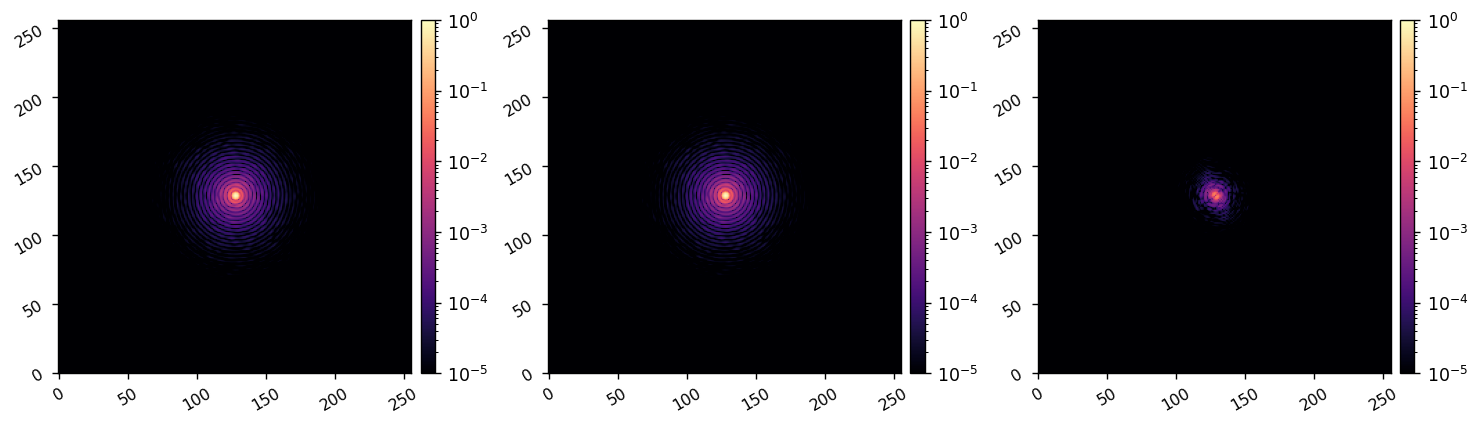

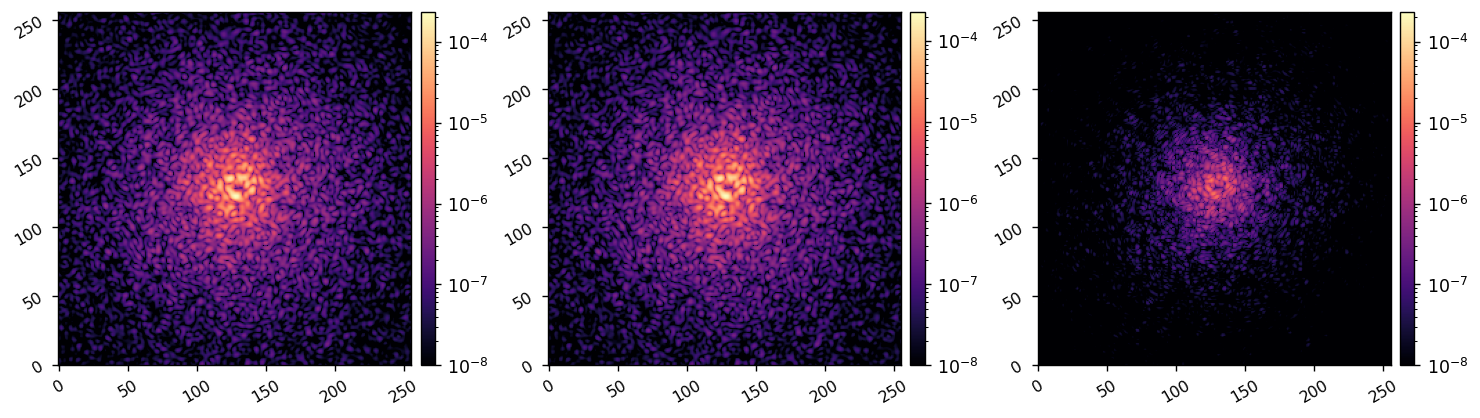

In [7]:
imshow3(ref_psf, model_psf, xp.abs(ref_psf - model_psf), 
        lognorm1=True, lognorm2=True, lognorm3=True, vmax3=1, 
        vmin1=1e-5, vmin2=1e-5, vmin3=1e-5)

imshow3(ref_coro_im, model_coro_im, xp.abs(ref_coro_im - model_coro_im), 
        lognorm1=True, lognorm2=True, lognorm3=True, vmax3=xp.max(ref_coro_im), 
        vmin1=1e-8, vmin2=1e-8, vmin3=1e-8)

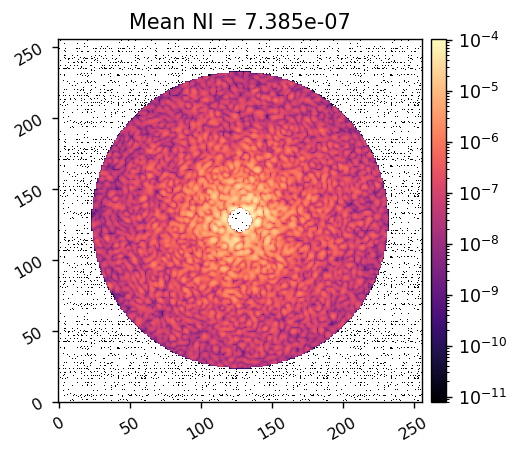

In [9]:
reload(utils)
I.zero_dms()
iwa = 3
owa = 36
rot = 0
control_mask = utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, irad=iwa, orad=owa, edge=None, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

imshow1(ref_coro_im*control_mask, f'Mean NI = {mean_ni:.3e}', lognorm=True)


	Cost-function J_delE: 0.021
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.021
	Total cost-function value: 1.000



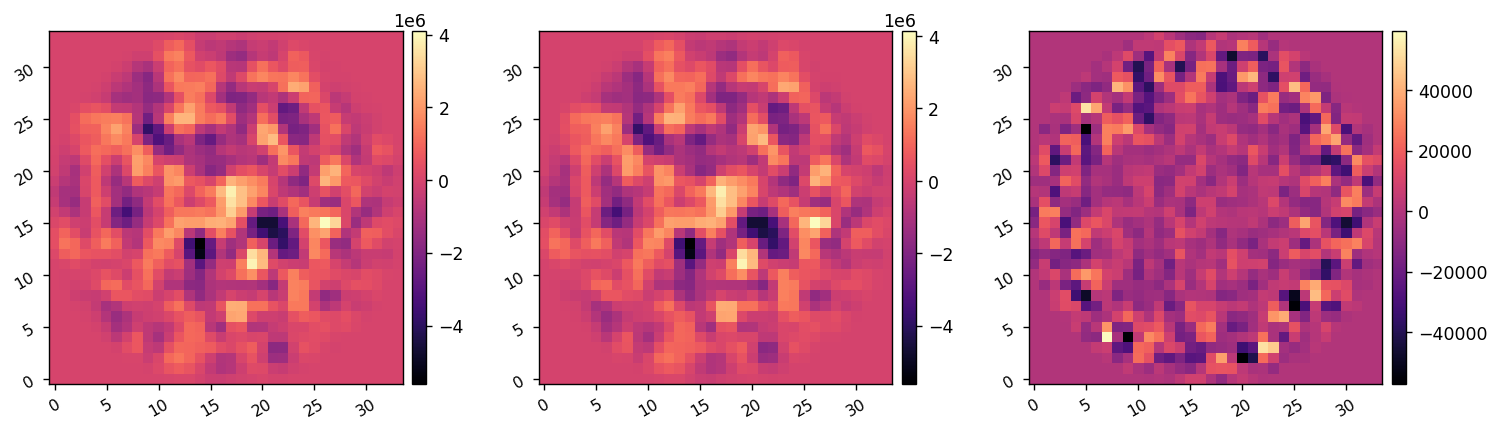

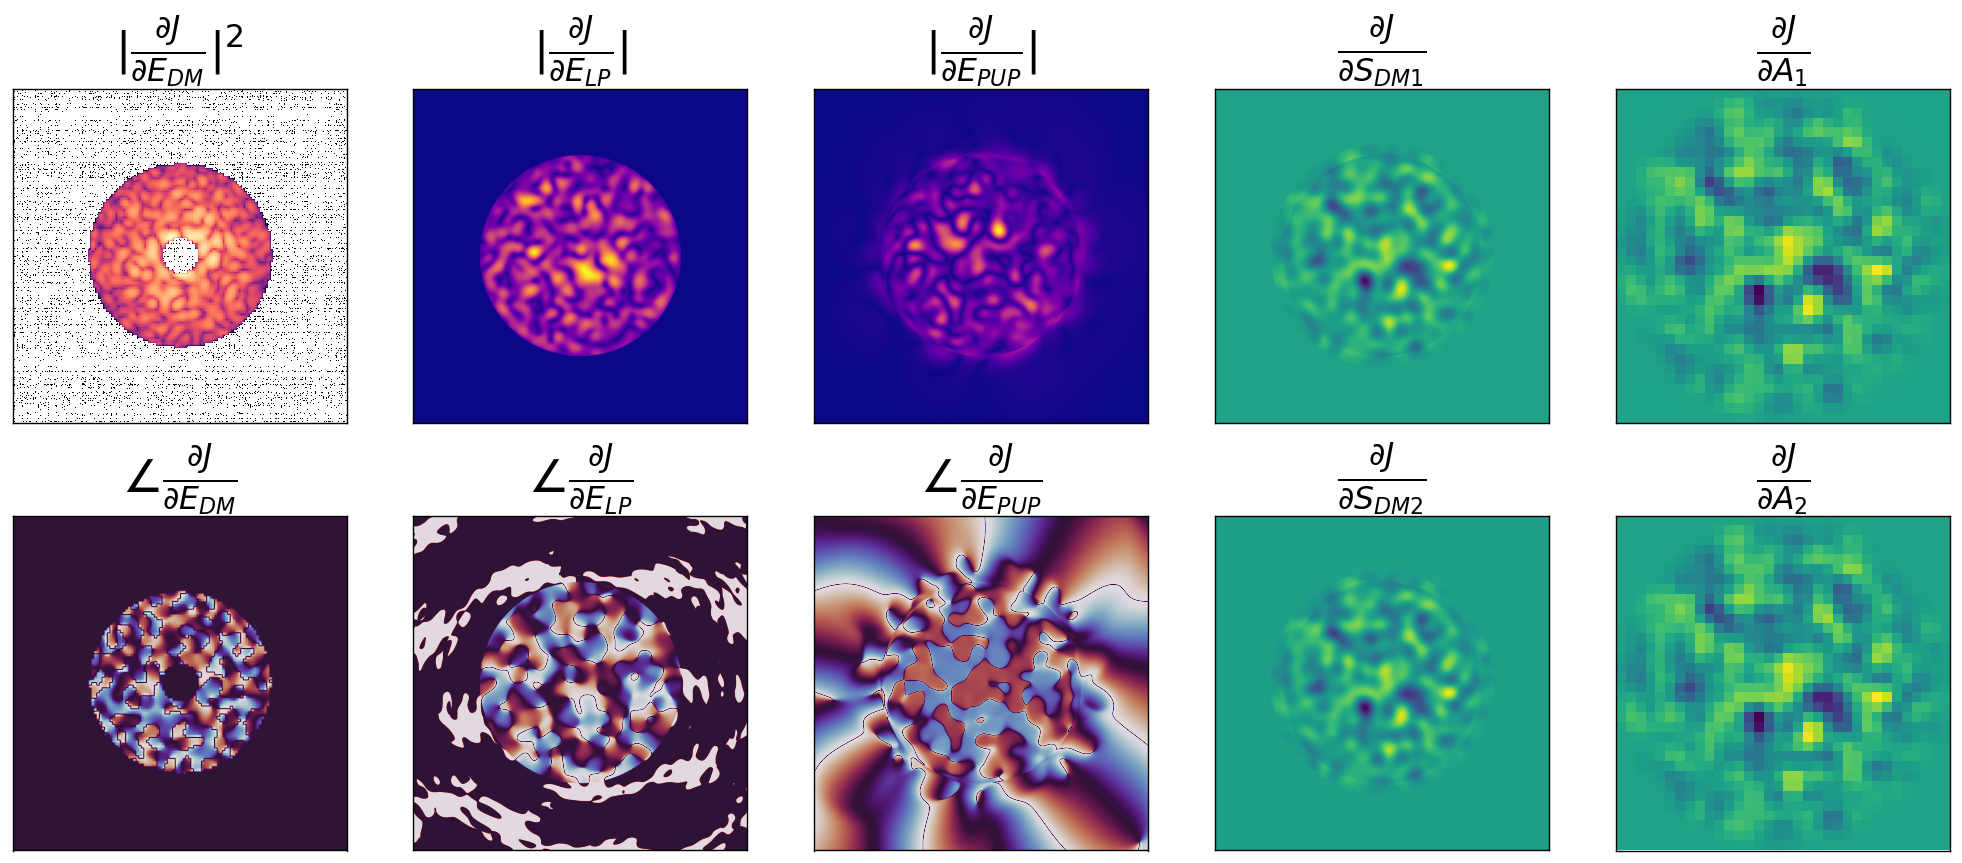

In [8]:
reload(fraunhofer)
current_acts = xp.zeros(M.Nacts)
# current_acts = fits.getdata('example-data/ad_test_acts.fits')

I.set_dm1(fraunhofer.acts_to_command(current_acts[:M.Nacts//2], M.dm_mask))
I.set_dm2(fraunhofer.acts_to_command(current_acts[M.Nacts//2:], M.dm_mask))
E_ab = I.calc_wf() * control_mask

E_FP_nom, E_EP, E_DM2P, DM1_PHASOR, DM2_PHASOR = M.forward(current_acts, I.wavelength, use_vortex=True, return_ints=True,)

rmad_vars = { 
    'current_acts':current_acts,
    'E_ab':E_ab, 
    'E_FP_NOM':E_FP_nom,
    'E_EP':E_EP,
    'E_DM2P':E_DM2P,
    'DM1_PHASOR':DM1_PHASOR,
    'DM2_PHASOR':DM2_PHASOR,
    'control_mask':control_mask,
    'wavelength':I.wavelength,
    'r_cond':1e-3,
}

del_acts = np.zeros(M.Nacts)
J, dJ_dA = fraunhofer.val_and_grad(
    del_acts, 
    M, 
    rmad_vars,
    verbose=True, 
    # plot=True, 
    fancy_plot=True,
)

dm1_grad = fraunhofer.acts_to_command(dJ_dA[:M.Nacts//2], M.dm_mask)
dm2_grad = fraunhofer.acts_to_command(dJ_dA[M.Nacts//2:], M.dm_mask)
imshow3(dm1_grad, dm2_grad, dm2_grad-dm1_grad)

In [9]:
reload(fraunhofer)

current_acts = xp.zeros(M.Nacts)
# current_acts = fits.getdata('example-data/ad_test_acts.fits')

I.set_dm1(fraunhofer.acts_to_command(current_acts[:M.Nacts//2], M.dm_mask))
I.set_dm2(fraunhofer.acts_to_command(current_acts[M.Nacts//2:], M.dm_mask))
E_ab = I.calc_wf() * control_mask
E_FP_nom, E_EP, E_DM2P, DM1_PHASOR, DM2_PHASOR = M.forward(current_acts, I.wavelength, use_vortex=True, return_ints=True,)

rmad_vars = { 
    'current_acts':current_acts,
    'E_ab':E_ab, 
    'E_FP_NOM':E_FP_nom,
    'E_EP':E_EP,
    'E_DM2P':E_DM2P,
    'DM1_PHASOR':DM1_PHASOR,
    'DM2_PHASOR':DM2_PHASOR,
    'control_mask':control_mask,
    'wavelength':I.wavelength,
    'r_cond':1e-3,
}

bfgs_tol = 1e-3
bfgs_opts = {
    'disp':True,
    # 'maxls':50,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

del_acts0 = np.zeros(M.Nacts)
res = minimize(
    fraunhofer.val_and_grad, 
    jac=True, 
    x0=del_acts0,
    args=(M, rmad_vars, True, False), 
    method='L-BFGS-B',
    tol=bfgs_tol,
    options=bfgs_opts,
)


	Cost-function J_delE: 0.021
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.021
	Total cost-function value: 1.000

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  5.61769D+06
	Cost-function J_delE: 0.006
	Cost-function J_c: 2366863905.325
	Cost-function normalization factor: 0.021
	Total cost-function value: 113407384951.315



 This problem is unconstrained.


	Cost-function J_delE: 0.037
	Cost-function J_c: 13.185
	Cost-function normalization factor: 0.021
	Total cost-function value: 633.516

	Cost-function J_delE: 0.154
	Cost-function J_c: 0.859
	Cost-function normalization factor: 0.021
	Total cost-function value: 48.546

	Cost-function J_delE: 1.276
	Cost-function J_c: 0.074
	Cost-function normalization factor: 0.021
	Total cost-function value: 64.687

	Cost-function J_delE: 5.696
	Cost-function J_c: 0.005
	Cost-function normalization factor: 0.021
	Total cost-function value: 273.124

	Cost-function J_delE: 0.081
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.021
	Total cost-function value: 3.879

	Cost-function J_delE: 0.003
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.021
	Total cost-function value: 0.165


At iterate    1    f=  1.65280D-01    |proj g|=  1.20135D+06
	Cost-function J_delE: 0.001
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.021
	Total cost-function value: 0.061



5.81673818181196e-06 5.220933767844232e-08


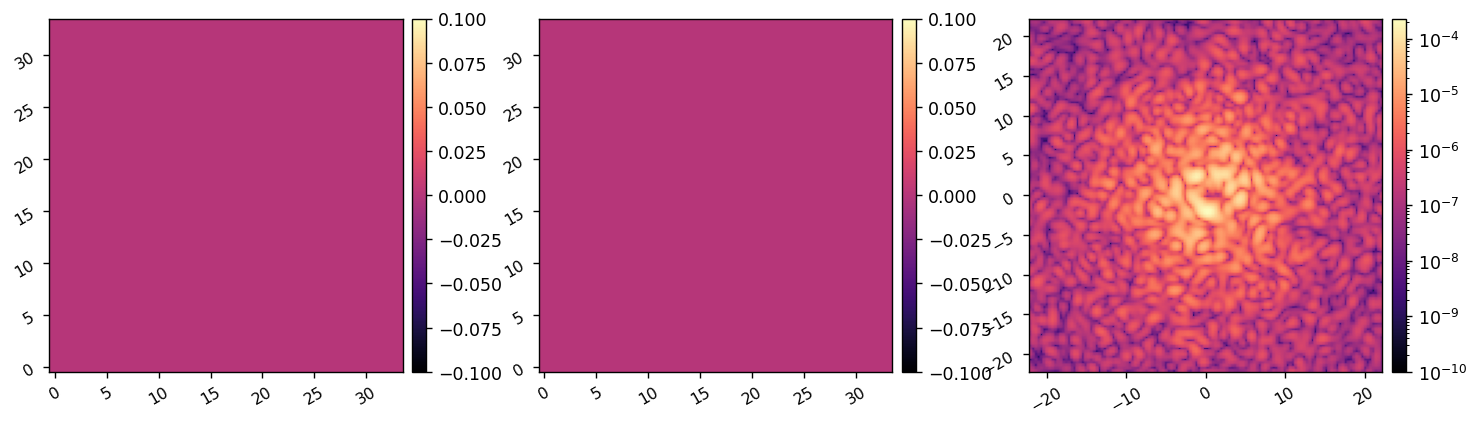

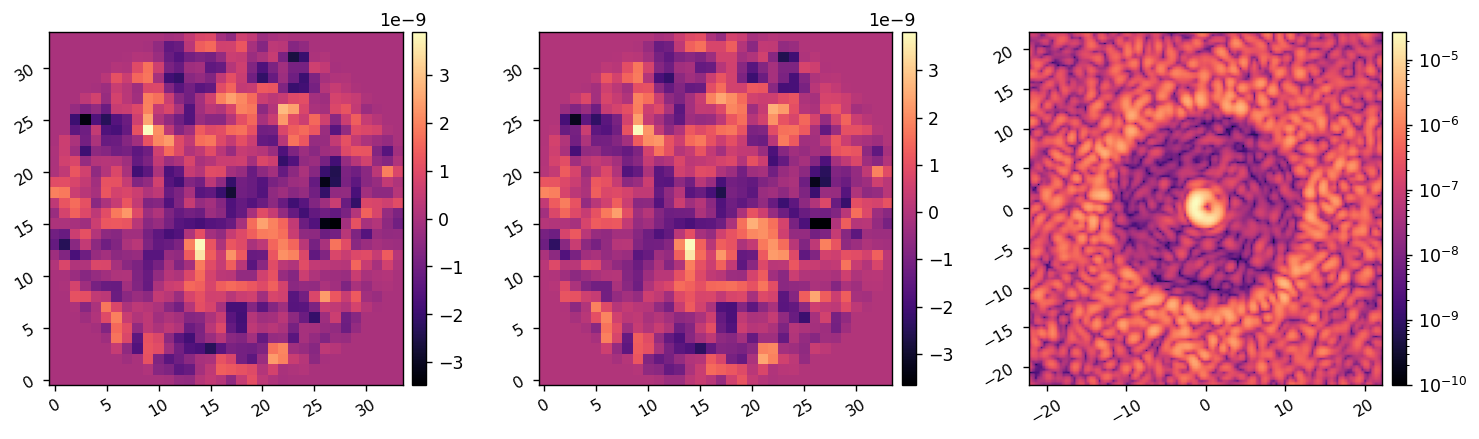

In [10]:
old_dm1 = fraunhofer.acts_to_command(current_acts[:M.Nacts//2], I.dm_mask)
old_dm2 = fraunhofer.acts_to_command(current_acts[M.Nacts//2:], I.dm_mask)
del_dm1 = fraunhofer.acts_to_command(res.x[:M.Nacts//2], I.dm_mask)
del_dm2 = fraunhofer.acts_to_command(res.x[M.Nacts//2:], I.dm_mask)

I.set_dm1(old_dm1)
I.set_dm2(old_dm2)
old_im = I.snap()

I.set_dm1(old_dm1 + del_dm1)
I.set_dm2(old_dm2 + del_dm2)
new_im = I.snap()

print(xp.mean(old_im[control_mask]), xp.mean(new_im[control_mask]))
imshow3(old_dm1, old_dm2, old_im, lognorm3=True, pxscl3=I.psf_pixelscale_lamDc, vmin3=1e-10,)
imshow3(del_dm1, del_dm2, new_im, lognorm3=True, pxscl3=I.psf_pixelscale_lamDc, vmin3=1e-10,)

In [18]:
utils.save_fits('ad_test_acts.fits', res.x)

Saved data to:  ad_test_acts.fits


In [10]:
I.zero_dms()
data = {
    # 'ref_im':ref_coro_im, 
    'images':[ref_coro_im],
    'efields':[],
    'dm1_commands':[],
    'del_dm1_commands':[],
    'dm2_commands':[],
    'del_dm2_commands':[],
    'reg_conds':[],
    'bfgs_tols':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
}

Computing E-field with model ...
Computing EFC command with L-BFGS
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14736     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  2.95970D+06


 This problem is unconstrained.



At iterate    1    f=  9.95654D-01    |proj g|=  2.46665D+06

At iterate    2    f=  9.75455D-01    |proj g|=  9.90037D+05

At iterate    3    f=  9.69391D-01    |proj g|=  1.03368D+06

At iterate    4    f=  9.56456D-01    |proj g|=  1.17694D+06

At iterate    5    f=  9.53252D-01    |proj g|=  8.85855D+05

At iterate    6    f=  9.45271D-01    |proj g|=  8.83933D+05

At iterate    7    f=  9.38681D-01    |proj g|=  8.65055D+05

At iterate    8    f=  9.37525D-01    |proj g|=  2.64695D+06

At iterate    9    f=  9.28216D-01    |proj g|=  5.74975D+05

At iterate   10    f=  9.25631D-01    |proj g|=  5.20921D+05

At iterate   11    f=  9.20081D-01    |proj g|=  1.07092D+06

At iterate   12    f=  9.14323D-01    |proj g|=  1.30091D+06

At iterate   13    f=  9.08138D-01    |proj g|=  1.00392D+06

At iterate   14    f=  9.02512D-01    |proj g|=  7.50708D+05

At iterate   15    f=  8.99187D-01    |proj g|=  1.72004D+06

At iterate   16    f=  8.94420D-01    |proj g|=  9.79950D+05

At iter

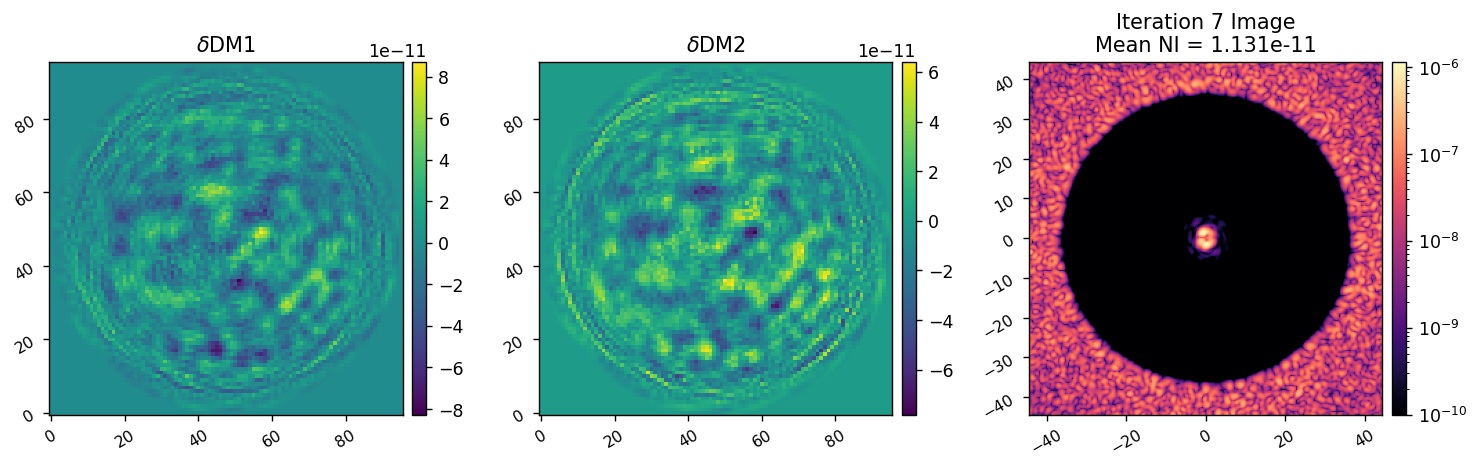

Computing E-field with model ...
Computing EFC command with L-BFGS
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14736     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  1.25480D+06


 This problem is unconstrained.



At iterate    1    f=  9.98998D-01    |proj g|=  1.07276D+06

At iterate    2    f=  9.94000D-01    |proj g|=  6.56566D+05

At iterate    3    f=  9.91858D-01    |proj g|=  7.43632D+05

At iterate    4    f=  9.86302D-01    |proj g|=  7.33968D+05

At iterate    5    f=  9.86041D-01    |proj g|=  2.37000D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14736      5     14      1     0     0   2.370D+06   9.860D-01
  F =  0.98604088912684562     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


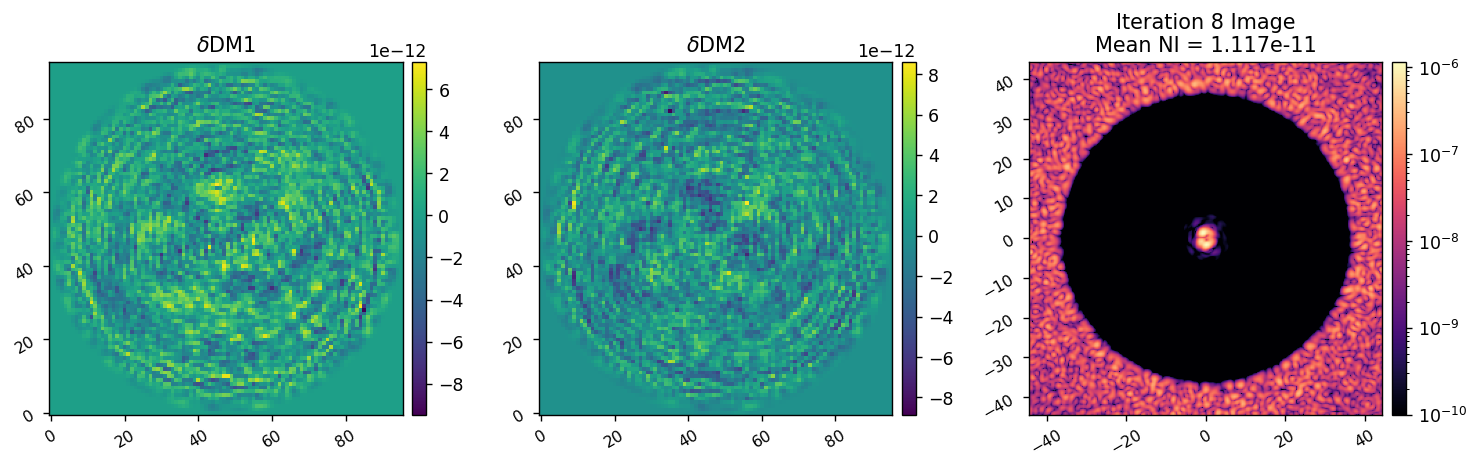

Computing E-field with model ...
Computing EFC command with L-BFGS
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14736     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  2.34346D+06


 This problem is unconstrained.



At iterate    1    f=  9.98353D-01    |proj g|=  1.98787D+06

At iterate    2    f=  9.92114D-01    |proj g|=  4.55131D+05

At iterate    3    f=  9.91335D-01    |proj g|=  4.73334D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14736      3     12      1     0     0   4.733D+05   9.913D-01
  F =  0.99133481277822533     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


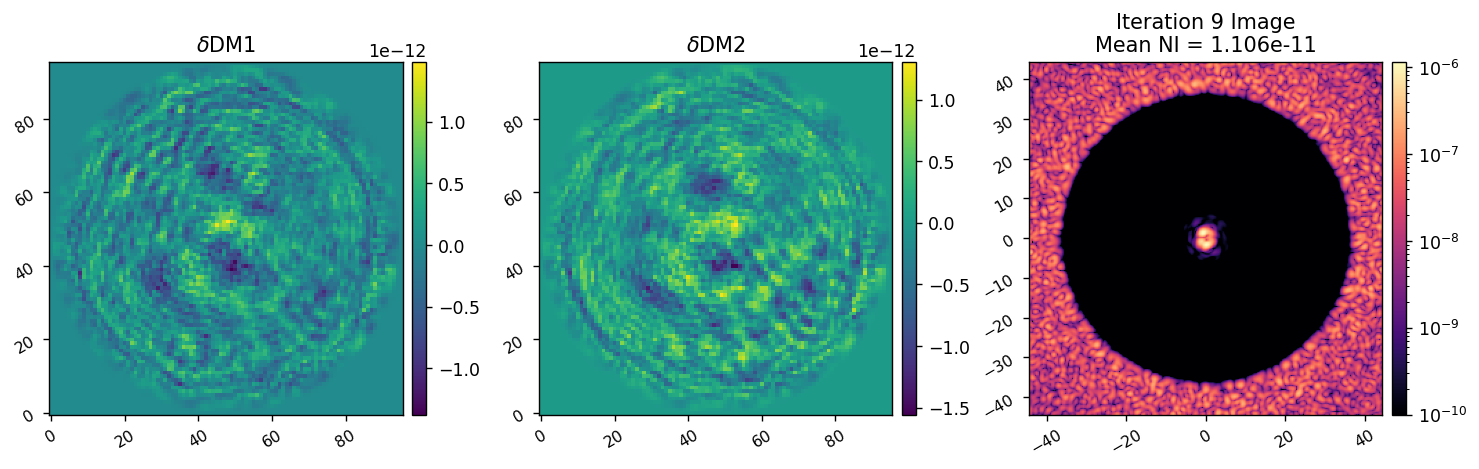

In [13]:
reload(fraunhofer)
reload(aefc)

r_cond = 1e-2
r_cond = 1e-3
# r_cond = 1e-4
# r_cond = 1e-5
# r_cond = 1e-6

bfgs_tol = 1e-2
bfgs_tol = 1e-3
# bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'maxiter':50,
    'disp':1,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

data = aefc.run(
    I, 
    M, 
    fraunhofer.val_and_grad, 
    control_mask, 
    data,
    Nitr=3, 
    reg_cond=r_cond,
    bfgs_tol=bfgs_tol,
    bfgs_opts=bfgs_opts,
    gain=1,
)

In [17]:
utils.save_pickle('aefc_34_data.pkl', data)

Saved data to:  aefc_34_data.pkl


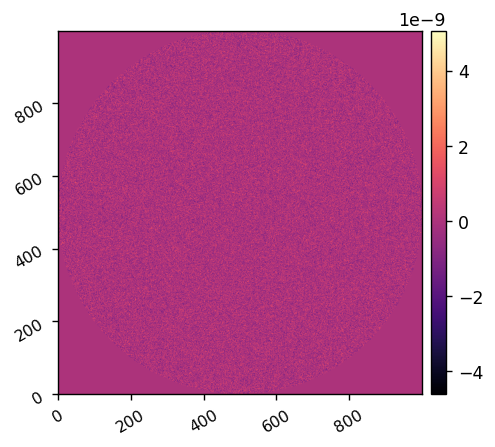

1.5692356715660787e-10


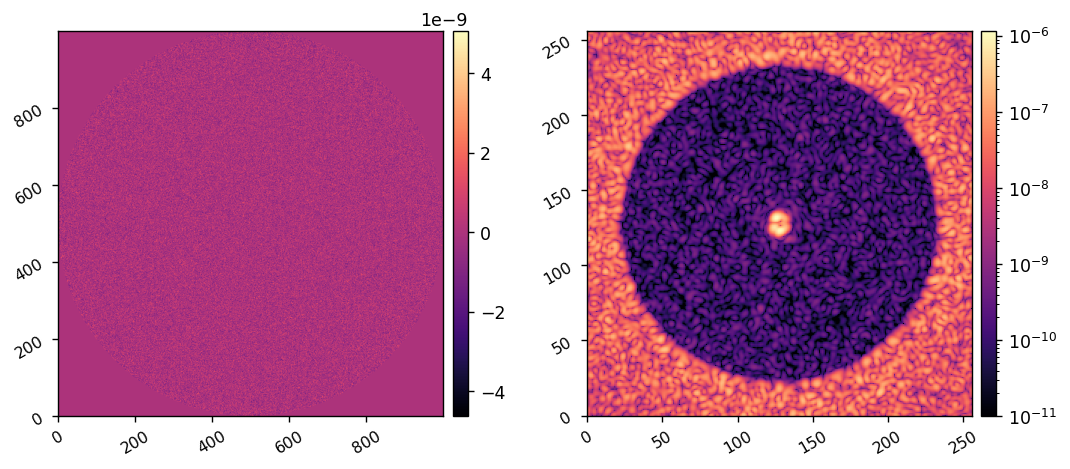

In [14]:
xp.random.seed(123)
rand_opd = 1e-9 * xp.random.randn(I.npix, I.npix) * I.BAP_MASK
imshow1(rand_opd)

I.WFE.opd = rand_opd

new_im = I.snap()
c = xp.mean(new_im[control_mask])
print(c)
imshow2(
    rand_opd, new_im,
    lognorm2=1, vmin2=1e-11,
)


In [39]:
Nopds = 10
Namps = 10
amps = xp.linspace(0, 5e-9, Namps)

contrasts = xp.zeros((Nopds,Namps))
for i in range(Nopds):
    xp.random.seed(123+i)
    rand_opd = xp.random.randn(I.npix, I.npix) * I.BAP_MASK
    for j in range(Namps):
        amp = amps[j]
        I.WFE.opd = amp * rand_opd

        new_im = I.snap()
        c = xp.mean(new_im[control_mask])
        print(c)

        contrasts[i,j] = c
    print()
        

2.241947611416599e-11
6.677196932074925e-11
1.9981557301240004e-10
4.2154782113534185e-10
7.319487353849503e-10
1.1309808415967357e-09
1.6185891931042573e-09
2.194701401047077e-09
2.859227671606123e-09
3.612060850140718e-09

2.241947611416599e-11
6.39383395716607e-11
1.8846554703847175e-10
3.960278287390694e-10
6.866372244210803e-10
1.0602910741561325e-09
1.516972015067684e-09
2.0566479839821505e-09
2.6792722259952065e-09
3.3847833089409657e-09

2.241947611416599e-11
6.623501348289605e-11
1.9730983270556435e-10
4.1559283344878957e-10
7.210186256249548e-10
1.1135075578304919e-09
1.5929657495097501e-09
2.1592851268294352e-09
2.812343462247443e-09
3.5520044177571763e-09

2.241947611416599e-11
6.273887952894249e-11
1.838482375938019e-10
3.856693939839919e-10
6.681108825648959e-10
1.0310679820924087e-09
1.4744227744705612e-09
1.998044206524164e-09
2.6017881552426697e-09
3.2854974964505265e-09

2.241947611416599e-11
6.335887369321221e-11
1.8614193296315628e-10
3.907215852191147e-10
6.7703483

In [40]:
mean_contrasts = xp.mean(contrasts, axis=0)

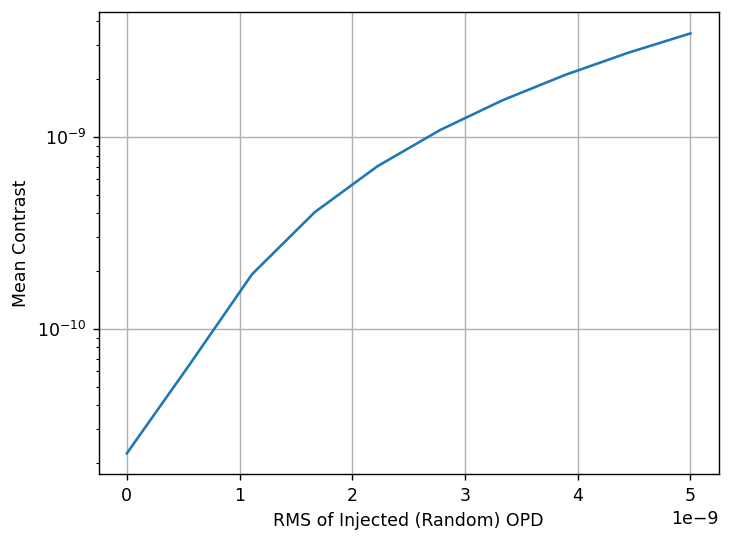

In [43]:
import matplotlib.pyplot as plt
plt.figure(dpi=125)
# plt.plot(ensure_np_array(amps), ensure_np_array(mean_contrasts))
plt.semilogy(ensure_np_array(amps), ensure_np_array(mean_contrasts))
plt.xlabel('RMS of Injected (Random) OPD')
plt.ylabel('Mean Contrast')
plt.grid()